In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras_preprocessing.image import ImageDataGenerator


from src.ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import concatenate

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MySimpleCnn_Feit-reduced-rgb-no-inception-residual"


/home/jelinek/recetox/src/notebooks/model_heaven


In [2]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256


    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x1 = keras.layers.Conv2D(filters=16, kernel_size=5, strides=(1, 1), padding='same')(inputs)
        x1 = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x1)
        x1 = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x1)

        x2 = keras.layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), padding='same')(x1)
        x2 = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x2)
        x2 = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x2)

        x1_padded = keras.layers.Conv2D(filters=32, kernel_size=1, strides=(2, 2))(x1)
        x1_padded = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x1_padded)

        add1 = keras.layers.Add()([x2, x1_padded])


        x3 = keras.layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same')(add1)
        x3 = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x3)
        x3 = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x3)

        add1_padded = keras.layers.Conv2D(filters=64, kernel_size=1, strides=(2, 2))(add1)
        add1_padded = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(add1_padded)

        add2 = keras.layers.Add()([add1_padded, x3])

        x4 = keras.layers.Conv2D(filters=128, kernel_size=5, strides=(1, 1), padding='same')(add2)
        x4 = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x4)
        x4 = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x4)

        add2_padded = keras.layers.Conv2D(filters=128, kernel_size=1, strides=(2, 2))(x3)
        add2_padded = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(add2_padded)

        add3 = keras.layers.Add()([x4, add2_padded])

        x5 = keras.layers.Conv2D(filters=256, kernel_size=5, strides=(1, 1), padding='same')(add3)
        x5 = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x5)
        x5 = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x5)

        add3_padded = keras.layers.Conv2D(filters=256, kernel_size=1, strides=(2, 2))(add3)
        add3_padded = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(add3_padded)

        add4 = keras.layers.Add()([x5, add3_padded])

        x6 = keras.layers.Conv2D(filters=512, kernel_size=5, strides=(1, 1), padding='same')(add4)

        x6 = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x6)
        x6 = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x6)

        x = keras.layers.Flatten()(x6)
        outputs = keras.layers.Dense(units=12, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayersResidual')
        model.summary()
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True, height_shift_range=0.15, width_shift_range=0.15,
                                           zoom_range=0.25, rotation_range=30)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                             class_mode='categorical', batch_size=self.params.batch_size,
                                             shuffle=True,
                                             target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

In [3]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

Model: "MySimpleCnnFewerLayersResidual"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 1216        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          max_pooling2d[0][0]              
_____________________________________________________________________

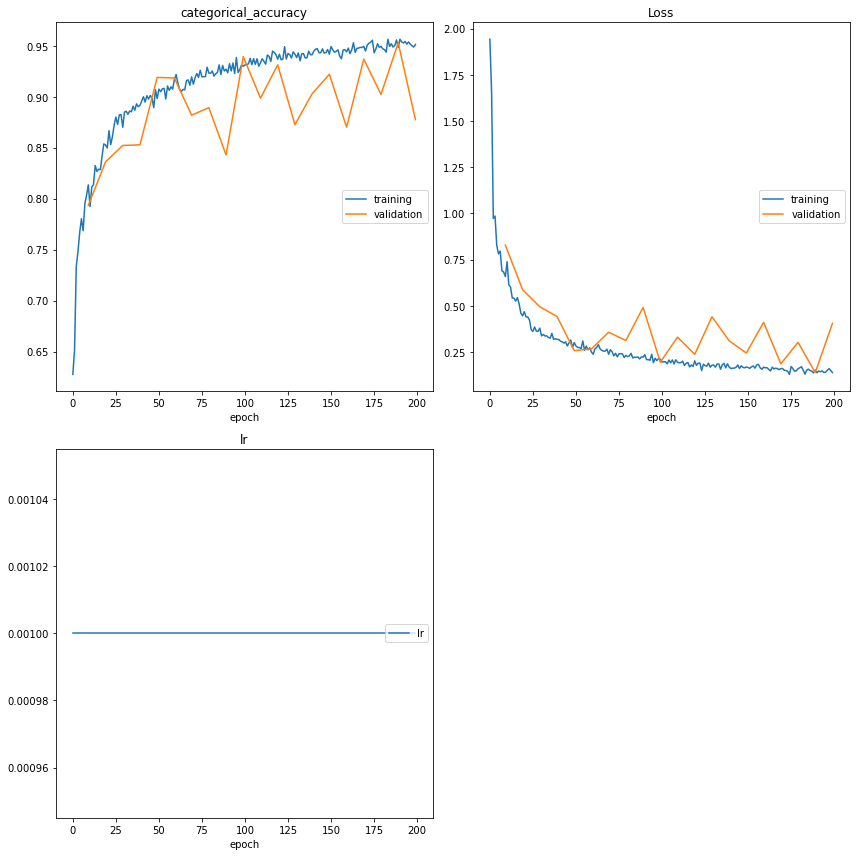

categorical_accuracy
	training         	 (min:    0.627, max:    0.956, cur:    0.951)
	validation       	 (min:    0.793, max:    0.953, cur:    0.878)
Loss
	training         	 (min:    0.128, max:    1.942, cur:    0.138)
	validation       	 (min:    0.138, max:    0.828, cur:    0.405)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
102/102 [==============================] - 5s 48ms/step - loss: 0.4048 - categorical_accuracy: 0.8776
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.4023ms
Confusion Matrix
[[335   0   0   0   0   0   0   0   0   0   0   0]
 [  8  46   9   1   0   0   0   0   0   0   0   0]
 [  3   3 138   0   1   0   0   0   0   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0   0   0]
 [  4   0   0   2 537   0   0   0   0   1   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  3   0   3   0   0   0  71   0   0   0   0   0]
 [  1   2   6   0   0   0   1  76   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1 

In [4]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [5]:
pipeline.save_pipeline()

/home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [6]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           name,
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1617 images belonging to 12 classes.
102/102 [==============================] - 5s 48ms/step - loss: 0.4048 - categorical_accuracy: 0.8776
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.3931ms
Confusion Matrix
[[335   0   0   0   0   0   0   0   0   0   0   0]
 [  8  46   9   1   0   0   0   0   0   0   0   0]
 [  3   3 138   0   1   0   0   0   0   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0   0   0]
 [  4   0   0   2 537   0   0   0   0   1   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  3   0   3   0   0   0  71   0   0   0   0   0]
 [  1   2   6   0   0   0   1  76   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0]
 [ 77   0   0   0   0   0   0   0   0   0 157   0]
 [ 71   0   1   0   0   0   0   0   0   0   0  46]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.67      1.00      0.8

In [7]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [8]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1)

Processing region 120 out of 120
Processing image took 1838.9168729782104 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-residual/ns-adenoca-colon-15071-2019-20x-he-4.tiff
Processing region 255 out of 255
Processing image took 4414.629497051239 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-residual/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
Processing region 255 out of 255
Processing image took 4234.062113761902 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-residual/ns-adenoca-colon-3043-2019-20x-he-a1.tiff
Processing region 567 out of 567
Processing image took 9614.68898820877 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-residual/pop-ca-colon-1708-2019-5-20x-he.tiff
[[513219   2819   2586     36     97      0    415   1535      0      0
    7936    468]
 [     0      0      0      0      0      0    